In [252]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd
import os
import emcee
import corner
from getdist import plots, gaussian_mixtures, MCSamples
import time

# Data

In [253]:
os.listdir()
os.listdir('Pantheon_SNeIa_dataset/')

['lcparam_DS17f.txt']

In [254]:
#binned Pantheon SNe Ia data
full_data = pd.read_csv('Pantheon_SNeIa_dataset/lcparam_DS17f.txt',sep=' ')

redshift = full_data['zcmb']
appmag = full_data['mb']
appmag_unc = full_data['dmb']

#absolute magnitude for Type 1a SNe
absmag = -19.25

#distance modulus = m - M
distmod = appmag - absmag
distmod.shape
distmod_unc = appmag_unc

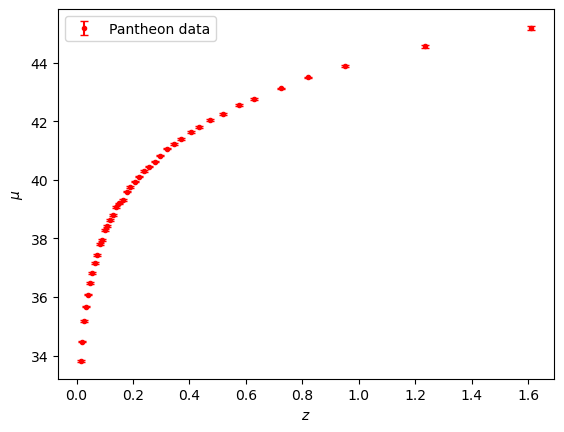

In [255]:
plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

# Numerical Solution

In [256]:
class AXIS_interval:
    
    def __init__(self, x_iv):
        self.m = x_iv[2]+1
        self.x = np.linspace(x_iv[0],x_iv[1],self.m)
        self.xrev = np.linspace(x_iv[1],x_iv[0],self.m)
        self.y = np.zeros((3,self.m))
        return


class AXIS_global:
    
    def __init__(self, x_iv, x_iv1):
        self.AXI = []
        # Input of xs,xe,n_sample per interval----------
        for i in range(len(x_iv)):
            self.AXI.append(AXIS_interval(x_iv[i]))
        self.iv1 = x_iv1     # index of interval [..., 1]
        
        self.niv = len(self.AXI)    # total no. of intervals
        self.n1 = 0                 # index of x=1
        for i in range(self.iv1+1):
            self.n1 += self.AXI[i].m
        self.n1 -= self.iv1+1

        self.m = 0
        for i in range(self.niv):
            self.m += self.AXI[i].m
        self.m -= self.niv-1
        self.x = np.zeros(self.m)
        k = 0
        for i in range(self.niv):
            for j in range(self.AXI[i].m):
                self.x[k+j] = self.AXI[i].x[j]
            k += self.AXI[i].m-1
        return

In [257]:
def prepare_solving():
    # start values, y0[2] = s(1) will be calculated
    y0 = np.zeros(3)
    y0[0] =  1    # a(1)
    y0[1] =  1    # H(1)

    # t-axis
    t_iv = []
    t_iv.append([0, 1,  200])
    t_iv.append([1, 3, 200])
    t_iv1 = 0
    AX = AXIS_global(t_iv, t_iv1)
        
    y    = np.zeros((3,AX.m))
    yp   = np.zeros(3)
    
    # z-axis, mu
    nz   = 200
    zmin = 0
    zmax = redshift[len(redshift)-1]+0.0001
    z    = np.linspace(zmin, zmax, nz)
    di   = np.zeros(nz)  
    mu   = np.zeros(nz)

    return AX, y0, y, yp, nz, z, di, mu

In [258]:
# Friedman equations
def FL_equations(x, y, yp, *args):
    Om   = args[0]
    Orad = args[1]
    Ok   = args[3]
    Os   = args[5]
    Os2  = Os/2
    Og   = args[2]*(3-5*Os)/(1-Os)**2/2
        
    err = 0
    a = y[0]
    H = y[1]
    s = y[2]
    if np.isfinite(a) and np.isfinite(H) and np.isfinite(s) and a > 1.e-14:
        a2 = a*a
        a3 = a2*a
        a4 = a3*a
        H2 = H*H
        s2 = s*s
        Oma3   = Om/a3
        Orada4 = Orad/a4
        Oka2   = Ok/a2
        Oss2   = (1-Os)*s2
        M      = 0.25*Oma3
        yp[0]  = a*H
        yp[1]  = -2*H2+2*M+Oka2+Oss2
        ks = (H2*s2-M*(0.75*Oma3+Orada4)
              +Os2*s2*(H2-(1-Os2)*s2-Oka2)
              +(Og-M)*(H2-Oma3-Orada4-Oka2-Oss2))
        if ks < 1.e-14: err = 2
        else: yp[2] = -H*s+2*np.sqrt(ks)
    else:
        err = 1
    return yp, err

In [259]:
# 1st order Runge Kutta
def FO_RK4(f, x, y, yp, *args):
    m   = len(x)         
    h   = x[1]-x[0]
    h2  = h/2
    err = 0
    nerr = -1
 
    for i in range(1, m):
        yh = y[:, i-1]
        k1, err1 = f(x[i-1],    yh,      yp, *args)
        k1 = k1*h
        k2, err2 = f(x[i-1]+h2, yh+k1/2, yp, *args)
        k2 = k2*h
        k3, err3 = f(x[i-1]+h2, yh+k2/2, yp, *args)
        k3 = k3*h
        k4, err4 = f(x[i-1]+h,  yh+k3,   yp, *args)
        k4 = k4*h
        y[:,i] = yh+(k1+2*k2+2*k3+k4)/6

        if err1+err2+err3+err4 != 0:
            err = 1
            nerr = i
            break
    return err, nerr

In [260]:
#Solving the differential equations
def calc_aHs(AX, y0, yp, *args):   
    imin = 0
    imax = AX.m-1
    y0[2] = np.sqrt(2*args[2]/(1-args[5]))  # s(1)
    
    k = AX.n1
    y[:,k] = y0
    for i in range(AX.iv1,-1,-1):
        xi = AX.AXI[i].xrev
        yi = AX.AXI[i].y
        yi[:,0] = y[:,k]
        err, nerr = FO_RK4(FL_equations, xi, yi, yp, *args)
        for j in range(AX.AXI[i].m):
            y[:,k-j] = yi[:,j]
        if err != 0: 
            imin = k-nerr+2
            break
        k -= AX.AXI[i].m-1
    
    k = AX.n1
    y[:,k] = y0
    for i in range(AX.iv1+1,AX.niv):
        xi = AX.AXI[i].x
        yi = AX.AXI[i].y
        yi[:,0] = y[:,k]
        err, nerr = FO_RK4(FL_equations, xi, yi, yp, *args)
        for j in range(AX.AXI[i].m):
            y[:,k+j] = yi[:,j]
        if err != 0:
            imax = k+nerr-1
            break
        k += AX.AXI[i].m-1
    return imin, imax, AX.x, y

In [261]:
def test_aHs(AX, y0, yp, *args):
    imin, imax, x, y = calc_aHs(AX, y0, yp, *args)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(0., 3.)
    ax.set_ylim(-0.5, 5.)
    plt.xlabel('$\\tau$')
    plt.ylabel('$a,H,s$')
    plt.xscale('linear')
    ax.axvline(x[imin],color="grey", ls='dotted', zorder=-1)
    ax.axvline(1.,color="grey", ls='dotted', zorder=-1)
    ax.axhline(0.,color="grey", ls='dotted', zorder=-1)
    ax.axhline(1.,color="grey", ls='dotted', zorder=-1)
    plt.plot(x[imin:imax], y[0,imin:imax], label='a')
    plt.plot(x[imin:imax], y[1,imin:imax], label='H')
    plt.plot(x[imin:imax], y[2,imin:imax], label='s')
    plt.legend()
    plt.show()
    return

In [262]:
#Calculate distance modulus
def calc_mu(AX, y0, y, yp, nz, z, di, mu, *args):
    H0   = args[4]*2.13312e-42
    H0_1 = 1/H0
    
    # Solve Friedman equations
    imin, imax, x, y = calc_aHs(AX, y0, yp, *args)

    # Integrand of luminosity distance    
    a = y[0]
    H = y[1]
    for i in range(nz):
        az = 1/(z[i]+1)
        az2 = az**2
        for j in range(imin+1,imax):
            if a[j] > az:
                di[i] = H0_1/(H[j]+(az-a[j-1])*(H[j]-H[j-1])/(a[j]-a[j-1]))
                break

    # mu
    dz2 = 0.5*(z[1]-z[0])
    mu[0] = 0.
    for i in range(1,nz):
        mu[i] = mu[i-1]+dz2*(di[i]+di[i-1])
    for i in range(1,nz):
        mu[i] = 5*np.log10((1+z[i])*mu[i]/1.5637382e38)+25
    return z[1:nz], mu[1:nz]

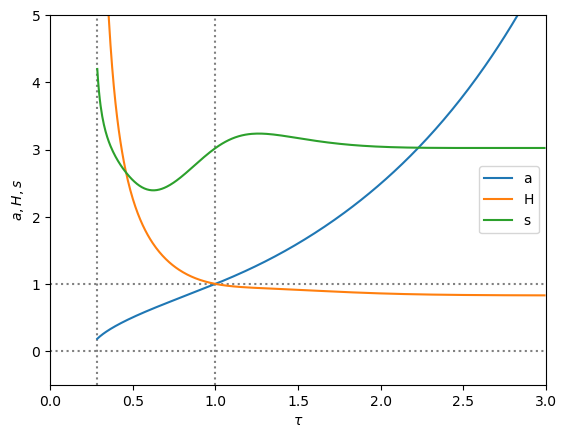


 elapsed time [sec] =  0.02300262451171875


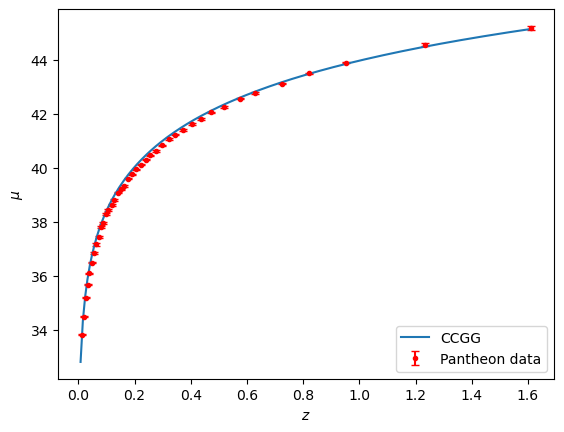

In [263]:
# Planck:
#         Om,    Orad,    Ol,     Ok,    h,     Os
args = (0.315, 5.44e-5, 0.685,  0.000, 0.674, 0.850)
AX, y0, y, yp, nz, z, di, mu = prepare_solving()
test_aHs(AX, y0, yp, *args)

starttime = time.time()
z_CG, mu_CG = calc_mu(AX, y0, y, yp, nz, z, di, mu, *args)
elapsedtime = time.time()-starttime
print('\n elapsed time [sec] = ', elapsedtime)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_xlim(-0.01, 0.1)
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(z_CG, mu_CG, label='CCGG')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend(loc='lower right')
plt.show()

# Interpolation

In [264]:
from scipy import interpolate

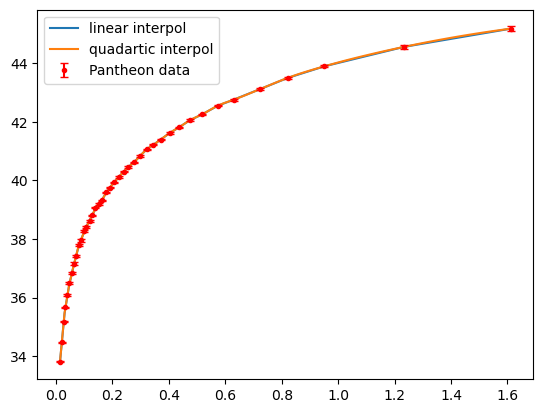

In [265]:
#Test
f1 = interpolate.interp1d(redshift, distmod, kind = 'linear')
f2 = interpolate.interp1d(redshift, distmod, kind = 'quadratic')

x_int = np.linspace(0.0140,1.6123,100)
plt.figure()
plt.plot(x_int, f1(x_int),label='linear interpol')
plt.plot(x_int, f2(x_int),label='quadartic interpol')
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.legend()
plt.show()

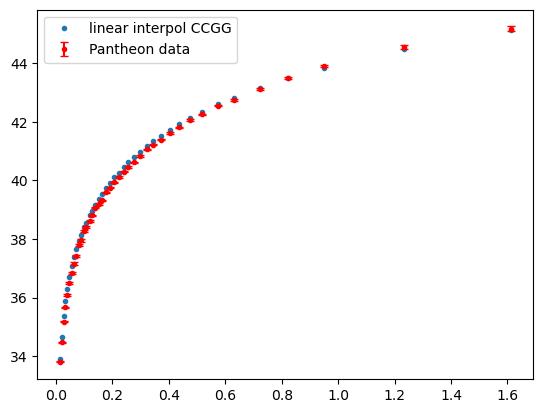

In [266]:
#Interpolate the 200 numerically computed values
f = interpolate.interp1d(z_CG, mu_CG, kind = 'linear')
#print(f(redshift))

#plot values of the interpolation function vs real data
mu_theo = f(redshift)
plt.figure()
plt.plot(redshift, mu_theo,'.',label='linear interpol CCGG')
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.legend()
plt.show()

# MCMC

In [267]:
#Set parameter vals for known:
Oradiation = 5.44e-5
Olambda = 0.685
Omatter = 0.3

#Set limits
Okmin = 1.5
Okmax = 6
Osmin = 0.70
Osmax = 0.82

In [268]:
# Define the log_likelihood function
def log_likelihood(params):
    Ok, Os = params
    args = (Omatter, Oradiation, Olambda,  Ok, 0.674, Os)
    z_CG, mu_CG = calc_mu(AX, y0, y, yp, nz, z, di, mu, *args)
    f = interpolate.interp1d(z_CG, mu_CG, kind = 'quadratic')
    return -0.5*np.sum(((distmod.values - f(redshift))/distmod_unc.values)**2 + np.log(2*np.pi*distmod_unc**2))

In [269]:
#log_likelihood([0.25,5e-5,0.7,0.0,0.1])

In [270]:
# Uniform log_prior
def log_prior(params):
    Ok, Os = params
    if Okmin <= Ok <= Okmax and Osmin <= Os <= Osmax:
        return -np.log((Okmax-Okmin)*(Osmax-Osmin))
    return -np.inf

In [271]:
#log_prior([0.25,5e-5,0.7,0.0,0.1])

In [272]:
#Product, resp. sum in logarithm form of likelihood and prior
def log_sum(params):
    # Compute the log-prior
    lp = log_prior(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    ll = log_likelihood(params)
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + ll

In [273]:
#log_sum([0.25,5e-5,0.7,0.0,0.1])

In [274]:
# Set the number of dimensions (i.e. the number of parameters)
ndim = 2

# Set the number of walkers
nwalkers = 7

# Define the range of values for each parameter
theta_min = [Okmin, Osmin]
theta_max = [Okmax, Osmax]

# Generate random starting positions for the walkers within the defined range
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:, i] = np.random.uniform(theta_min[i], theta_max[i], size=nwalkers)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, args=())

In [275]:
# Run the sampler for a specified number of iterations
n_iterations = 10000
sampler.run_mcmc(p0, n_iterations, progress=True)

C:\Users\armin\AppData\Local\Temp\ipykernel_11312\1167578942.py:26: RuntimeWarning: invalid value encountered in log10
  mu[i] = 5*np.log10((1+z[i])*mu[i]/1.5637382e38)+25
100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [30:56<00:00,  5.39it/s]


State([[1.70279875 0.77093716]
 [3.30918074 0.74620043]
 [4.63194671 0.75473363]
 [3.74299742 0.74539766]
 [5.86464779 0.71293268]
 [5.8122385  0.73670851]
 [1.64159938 0.81426742]], log_prob=[0.61618614 0.61618614 0.61618614 0.61618614 0.61618614 0.61618614
 0.61618614], blobs=None, random_state=('MT19937', array([1978298035,  539326391, 2901457275,  338712925, 4115315450,
       2875649427,  191282860, 2550722592, 4281035442, 2717101558,
       2014903107, 3324539686, 3208712102,  284105560, 3510268968,
        989157419,  910094303, 1385671828, 1546258768, 4160643997,
       1296390486, 3286257751, 2902799195, 2519697303, 3518925056,
       3437105073, 4278393003, 4168213485,   97303078, 4196848408,
       1628273493, 1161021637,   41606726, 2221032543, 1107096923,
       2029990209,  893194048, 1749881697, 3563091304, 3926366923,
       2973517586, 3743793005,  317090922,  451251094, 3075272126,
       2763919333, 1114708322,  496063869, 3977465153, 2482484637,
       1310528659, 4

In [276]:
# Get the chain of samples produced by the sampler
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
samples = sampler.chain[:, :, :]
print(sampler.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 1000
final_samples = samples[:,burnin:, :]
print(final_samples.shape)

(7, 10000, 2)
(7, 9000, 2)


(63000, 2)


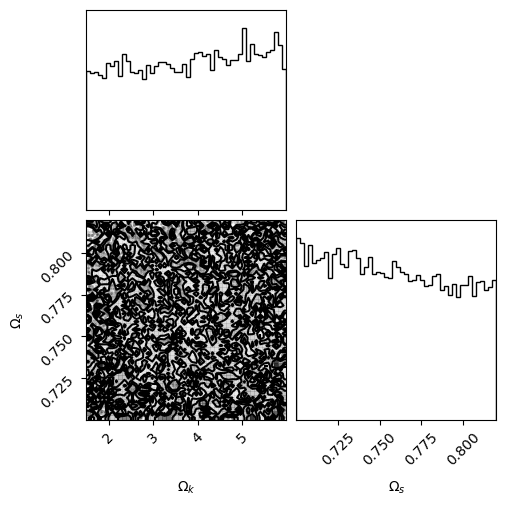

In [277]:
# Flatten the chain of samples
flat_samples = final_samples.reshape(-1, ndim)
print(flat_samples.shape)

# Plot the corner plot using the flattened samples
figure = corner.corner(flat_samples,bins=50, labels=['$\Omega_k$','$\Omega_s$'])

# Show the plot
plt.show()

Removed no burn in


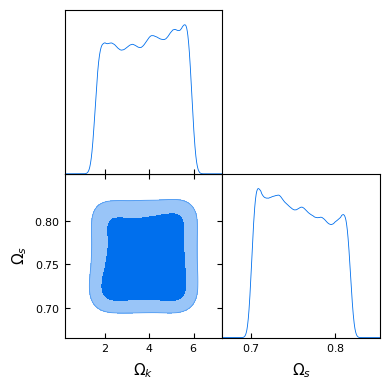

In [278]:
names = ['Omega_k','Omega_s']
labels =  ['\Omega_k', '\Omega_s']
samples_new = MCSamples(samples=np.array(flat_samples),names=names,labels=labels)
g = plots.get_subplot_plotter()
g.triangle_plot(samples_new, filled=True)

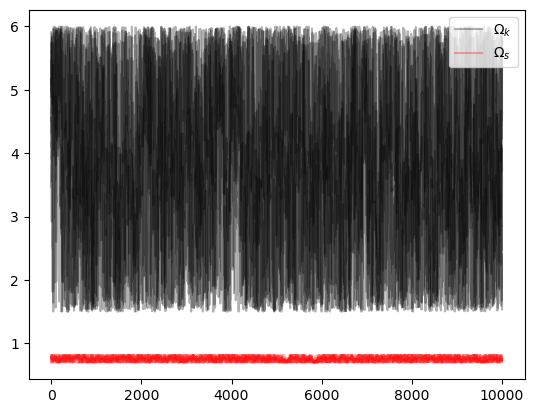

In [279]:
plt.figure()
plt.plot(samples[0,:,0].T, '-', color='k', alpha=0.3,label='$\Omega_k$')
plt.plot(samples[1:,:,0].T, '-', color='k', alpha=0.3)
plt.plot(samples[0,:,1].T, '-', color='r', alpha=0.3,label='$\Omega_s$')
plt.plot(samples[1:,:,1].T, '-', color='r', alpha=0.3)
plt.legend()
plt.show()

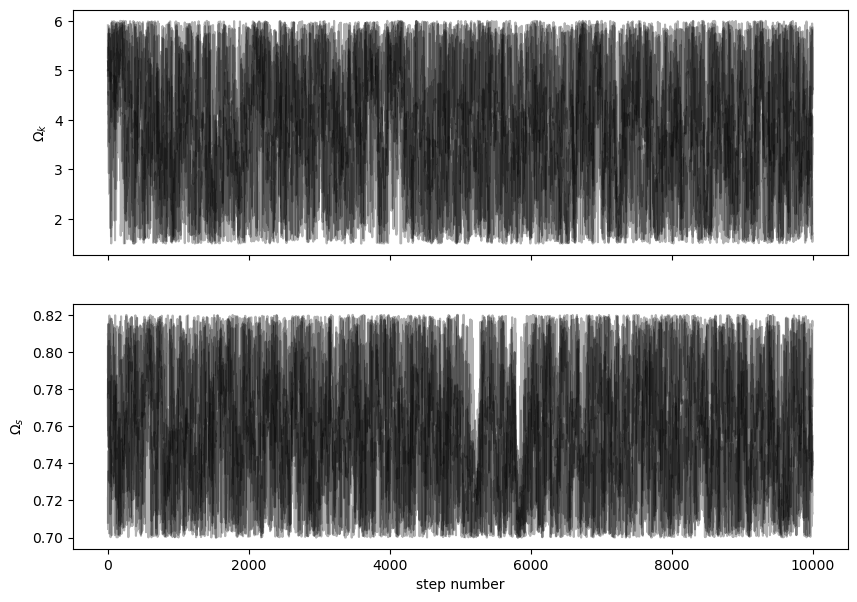

In [280]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\Omega_k$", "$\Omega_s$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, "k-", alpha=0.3)
    #ax.set_xlim(0, 10000)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [281]:
sampler.chain[:,:,0].T.shape

(10000, 7)

In [282]:
#mean and std dev of Om_k
m1 = np.mean(flat_samples[:,0])
std1 = np.std(flat_samples[:,0])
print('Mean of Om_k = ',m1)
print('Std dev of Om_k = ',std1)

#mean and std dev of Om_s
m2 = np.mean(flat_samples[:,1])
std2 = np.std(flat_samples[:,1])
print('Mean of Om_s = ',m2)
print('Std dev of Om_s = ',std2)

Mean of Om_k =  3.812883615450707
Std dev of Om_k =  1.300916632419371
Mean of Om_s =  0.7571789096731721
Std dev of Om_s =  0.03472280586499998


C:\Users\armin\AppData\Local\Temp\ipykernel_11312\1167578942.py:26: RuntimeWarning: invalid value encountered in log10
  mu[i] = 5*np.log10((1+z[i])*mu[i]/1.5637382e38)+25


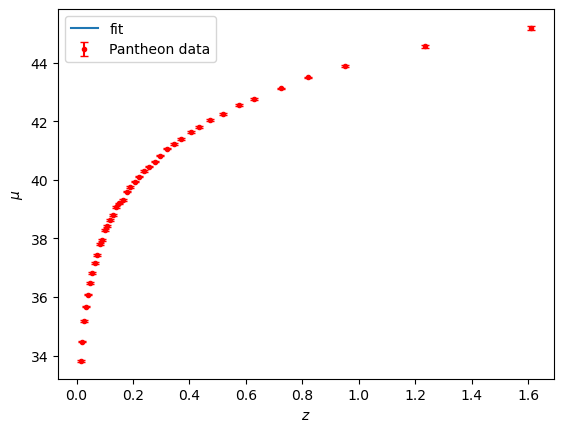

In [283]:
#Best fit
args = (Omatter, Oradiation, Olambda,  m1, 0.674, m2)
z_fit, mu_fit = calc_mu(AX, y0, y, yp, nz, z, di, mu, *args)

plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(z_fit,mu_fit,label='fit')
plt.plot
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()